In [1]:
import pandas
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas
from collections import defaultdict
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import seaborn as sns
import humanize


# U for Uber, T for T4c, O for OpenStreetMap
START_DAY=21
END_DAY=27 # incl.
UBASEPATH = Path('/iarai/public/t4c/uber')
TBASEPATH = Path('/iarai/public/t4c/data_pipeline/release20221028_historic_uber')
OBASEPATH = Path('/iarai/public/t4c/osm')

CITY = "london"
YEAR = 2019
MONTH = 10

DAYTIME_START_HOUR=8
DAYTIME_END_HOUR=18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
highway_ordering = [
    'motorway', 'motorway_link', 
    'trunk','trunk_link', 
    'primary','primary_link',
    'secondary', 'secondary_link', 
    'tertiary','tertiary_link',
    'unclassified',  'residential',
    'living_street', 'service',
    'cycleway', 'road', 'construction']

In [3]:
plt.rcParams["axes.labelsize"] = 24

In [4]:
simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']

In [5]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

## Load Uber segment speeds daytime and within bounding box

In [6]:
uspeeds_df = pandas.read_parquet(UBASEPATH / f'movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet')
uspeeds_df = uspeeds_df[(uspeeds_df["day"]>=START_DAY)&(uspeeds_df["day"]<=END_DAY)]
uspeeds_df['speed_kph_mean'] = uspeeds_df['speed_mph_mean'] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={'osm_start_node_id': 'u', 'osm_end_node_id': 'v', "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [ f"{u}_{v}_{osmid}" for u,v,osmid in zip(uspeeds_df["u"],uspeeds_df["v"],uspeeds_df["osmid"])]
uspeeds_df

,u,v,osmid,year,month,day,hour,speed_mph_mean,speed_mph_stddev,speed_kph_mean,gkey
8,1343922650,108500,8179128,2019,10,21,12,11.078,1.550,17.828269,1343922650_108500_8179128
10,1343922650,108500,8179128,2019,10,24,18,11.507,6.372,18.518675,1343922650_108500_8179128
14,1343922650,108500,8179128,2019,10,27,20,9.204,3.180,14.812365,1343922650_108500_8179128
19,1343922650,108500,8179128,2019,10,25,15,10.188,3.018,16.395956,1343922650_108500_8179128
23,1343922650,108500,8179128,2019,10,21,9,9.261,4.482,14.904098,1343922650_108500_8179128
...,...,...,...,...,...,...,...,...,...,...,...
47121766,4804443645,3863127062,688989358,2019,10,26,9,18.519,6.165,29.803367,4804443645_3863127062_688989358
47121774,4804443645,3863127062,688989358,2019,10,24,20,15.994,2.497,25.739784,4804443645_3863127062_688989358
47121781,4804443645,3863127062,688989358,2019,10,24,8,15.435,2.578,24.840163,4804443645_3863127062_688989358
47121785,4804443645,3863127062,688989358,2019,10,21,19,14.349,4.693,23.092420,4804443645_3863127062_688989358


## Load our segment speeds and aggregate by hour

In [7]:
tspeeds_l = []
for i in range(START_DAY,END_DAY+1):
    f = TBASEPATH / 'speed_classes' / CITY / f'speed_classes_{YEAR}-{MONTH}-{i}.parquet'
    print(f)
    df = pd.read_parquet(f)
    # ['u', 'v', 'gkey', 'osmid', 'day', 't', 'volume_class', 'volume','median_speed_kph', 'mean_speed_kph', 'std_speed_kph', 'free_flow_kph'],
#     print(df.columns)
    df["date"]=df["day"]
    df["year"]=2019
    df["month"]=10
    df["day"]=i
    df["hour"]= df["t"]//4
    df = df[['u', 'v', 'gkey','year', 'month','day', 'hour', 'volume', 'volume_class', 'median_speed_kph', 'free_flow_kph', 'std_speed_kph']].groupby(
    by=['u', 'v', 'gkey','year', 'month', 'day','hour']).agg(
        volume_class=("volume_class", "mean"),
        volume=("volume", "mean"),
        std_speed_kph=("std_speed_kph", "mean"),
        median_speed_kph=("median_speed_kph", "mean"),
        free_flow_kph=("free_flow_kph", "first")
    ).reset_index()
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
#tspeeds_df = tspeeds_df.rename(columns={'osmid': 'osm_way_id'})
tspeeds_df

/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-21.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-22.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-23.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-24.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-25.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-26.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-27.parquet


,u,v,gkey,year,month,day,hour,volume_class,volume,std_speed_kph,median_speed_kph,free_flow_kph
0,78112,25508583,78112_25508583_129375498,2019,10,21,7,3.000000,3.0,19.411765,19.411765,45.176471
1,78112,25508583,78112_25508583_129375498,2019,10,21,8,4.000000,11.5,2.376391,44.588235,45.176471
2,78112,25508583,78112_25508583_129375498,2019,10,21,9,2.000000,2.5,2.608359,45.176471,45.176471
3,78112,25508583,78112_25508583_129375498,2019,10,21,10,4.333333,6.0,12.524114,42.823529,45.176471
4,78112,25508583,78112_25508583_129375498,2019,10,21,11,4.000000,6.5,7.879914,26.705882,45.176471
...,...,...,...,...,...,...,...,...,...,...,...,...
1380556,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,16,1.000000,2.0,1.882353,52.705882,47.294118
1380557,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,18,3.000000,3.0,0.470588,37.176471,47.294118
1380558,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,20,1.000000,2.0,0.470588,42.352941,47.294118
1380559,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,22,1.000000,2.0,2.117647,56.705882,47.294118


In [8]:
u_ids = set(zip(uspeeds_df["u"],uspeeds_df["v"],uspeeds_df["gkey"]))
u_ids

{(26371595, 1257231427, '26371595_1257231427_130451080'),
 (1307547972, 33206235, '1307547972_33206235_8098607'),
 (149541853, 149541409, '149541853_149541409_235873974'),
 (6228487664, 6226254624, '6228487664_6226254624_7413441'),
 (90050974, 33118766, '90050974_33118766_30144512'),
 (251162596, 8695958, '251162596_8695958_4522432'),
 (25549859, 25549856, '25549859_25549856_4272763'),
 (6366090928, 1744032360, '6366090928_1744032360_162539339'),
 (469669734, 246846418, '469669734_246846418_680425703'),
 (102022, 25497445, '102022_25497445_61960154'),
 (2919830, 412196435, '2919830_412196435_35140723'),
 (30427583, 30427584, '30427583_30427584_4763858'),
 (6053784938, 25475669, '6053784938_25475669_4340872'),
 (1259741203, 1259741207, '1259741203_1259741207_110265360'),
 (1987112714, 1987112782, '1987112714_1987112782_25262523'),
 (21449876, 20828776, '21449876_20828776_3989470'),
 (1124698459, 21647085, '1124698459_21647085_52047706'),
 (27797967, 27797959, '27797967_27797959_15669120

In [9]:
t_ids = set(zip(tspeeds_df["u"],tspeeds_df["v"],tspeeds_df["gkey"]))
t_ids

{(196830, 196828, '196830_196828_2532353'),
 (30155677, 151173327, '30155677_151173327_4731834'),
 (1307547972, 33206235, '1307547972_33206235_8098607'),
 (30759374, 3103236988, '30759374_3103236988_305659853'),
 (196090, 4978239410, '196090_4978239410_8119743'),
 (25549859, 25549856, '25549859_25549856_4272763'),
 (982344387, 460483393, '982344387_460483393_84538508'),
 (126504590, 126504765, '126504590_126504765_511366444'),
 (204618, 1869207242, '204618_1869207242_140234626'),
 (4013337056, 88292781, '4013337056_88292781_132810610'),
 (469669734, 246846418, '469669734_246846418_680425703'),
 (2265967110, 209310, '2265967110_209310_217323579'),
 (102022, 25497445, '102022_25497445_61960154'),
 (2919830, 412196435, '2919830_412196435_35140723'),
 (30427583, 30427584, '30427583_30427584_4763858'),
 (25498546, 25498560, '25498546_25498560_77238757'),
 (25496795, 25496831, '25496795_25496831_4305893'),
 (6053784938, 25475669, '6053784938_25475669_4340872'),
 (1259741203, 1259741207, '125

In [10]:
# does not hold with the restricted time frame...
# assert t_ids.issubset(u_ids)

## Restrict to daytime only 

In [11]:
tspeeds_df = tspeeds_df[(tspeeds_df["hour"]>=DAYTIME_START_HOUR)&(tspeeds_df["hour"]<DAYTIME_END_HOUR)] 
tspeeds_df

,u,v,gkey,year,month,day,hour,volume_class,volume,std_speed_kph,median_speed_kph,free_flow_kph
1,78112,25508583,78112_25508583_129375498,2019,10,21,8,4.000000,11.5,2.376391,44.588235,45.176471
2,78112,25508583,78112_25508583_129375498,2019,10,21,9,2.000000,2.5,2.608359,45.176471,45.176471
3,78112,25508583,78112_25508583_129375498,2019,10,21,10,4.333333,6.0,12.524114,42.823529,45.176471
4,78112,25508583,78112_25508583_129375498,2019,10,21,11,4.000000,6.5,7.879914,26.705882,45.176471
5,78112,25508583,78112_25508583_129375498,2019,10,21,12,1.000000,2.0,16.000000,36.705882,45.176471
...,...,...,...,...,...,...,...,...,...,...,...,...
1380552,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,12,1.000000,2.0,0.000000,53.647059,47.294118
1380553,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,13,2.000000,2.5,2.294118,45.000000,47.294118
1380554,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,14,3.666667,5.0,1.058824,45.607843,47.294118
1380555,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,15,1.000000,2.0,0.000000,46.588235,47.294118


In [12]:
uspeeds_df = uspeeds_df[(uspeeds_df["hour"]>=DAYTIME_START_HOUR)&(uspeeds_df["hour"]<DAYTIME_END_HOUR)] 
uspeeds_df

,u,v,osmid,year,month,day,hour,speed_mph_mean,speed_mph_stddev,speed_kph_mean,gkey
8,1343922650,108500,8179128,2019,10,21,12,11.078,1.550,17.828269,1343922650_108500_8179128
19,1343922650,108500,8179128,2019,10,25,15,10.188,3.018,16.395956,1343922650_108500_8179128
23,1343922650,108500,8179128,2019,10,21,9,9.261,4.482,14.904098,1343922650_108500_8179128
32,1343922650,108500,8179128,2019,10,27,11,9.877,2.190,15.895451,1343922650_108500_8179128
38,1343922650,108500,8179128,2019,10,25,16,10.145,3.661,16.326754,1343922650_108500_8179128
...,...,...,...,...,...,...,...,...,...,...,...
47121757,4804443645,3863127062,688989358,2019,10,24,9,15.198,4.081,24.458749,4804443645_3863127062_688989358
47121763,4804443645,3863127062,688989358,2019,10,21,10,17.880,5.863,28.774999,4804443645_3863127062_688989358
47121764,4804443645,3863127062,688989358,2019,10,21,16,16.509,4.731,26.568594,4804443645_3863127062_688989358
47121766,4804443645,3863127062,688989358,2019,10,26,9,18.519,6.165,29.803367,4804443645_3863127062_688989358


## Merge with road graph in bounding box

In [13]:
df_edges = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")
df_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,19.407060,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...,Outer Circle
1,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,63.857249,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...,Outer Circle
2,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,12.645031,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x94o\x1...,York Gate
3,99936_4544836433_233623258,99936,4544836433,233623258,48.3,30 mph,unclassified,,,,47.220818,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x94o\x1...,York Gate
4,99937_200047_4257261,99937,200047,4257261,48.3,30 mph,unclassified,,,,59.033945,b'\x01\x02\x00\x00\x00\x07\x00\x00\x005\x9a\\\...,York Gate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6577730921_254761207_358627524,6577730921,254761207,358627524,46.2,,tertiary,,,,134.082828,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xdfw\xc...,Golborne Road
234304,6577730921_6577730928_8227762,6577730921,6577730928,8227762,36.3,,residential,,,,51.325126,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xdfw\xc...,Bevington Road
234305,6577730928_2379175_700435511,6577730928,2379175,700435511,36.3,,residential,,,,57.576832,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x96\x7f...,Bevington Road
234306,6577745911_36728211_646234311,6577745911,36728211,646234311,48.3,30 mph,primary,,,,305.243521,b'\x01\x02\x00\x00\x00\x07\x00\x00\x00\x82\xdb...,Coombe Lane


In [14]:
df_nodes = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
df_nodes

,node_id,x,y,geometry
0,78112,-0.145792,51.526976,b'\x01\x01\x00\x00\x00R\xaf\x00KS\xa9\xc2\xbfq...
1,99936,-0.152791,51.523611,b'\x01\x01\x00\x00\x00\x94o\x11s\xa4\x8e\xc3\x...
2,99937,-0.152024,51.523018,b'\x01\x01\x00\x00\x005\x9a\\\x8c\x81u\xc3\xbf...
3,99940,-0.155763,51.523085,b'\x01\x01\x00\x00\x00va\xb5C\r\xf0\xc3\xbf\x0...
4,101818,-0.148104,51.535179,b'\x01\x01\x00\x00\x00\xd4\xe7\xb4\xb8\x10\xf5...
...,...,...,...,...
140407,6577710674,-0.225660,51.505155,"b""\x01\x01\x00\x00\x00'\x8c\xc1\x1en\xe2\xcc\x..."
140408,6577710675,-0.227720,51.502322,"b'\x01\x01\x00\x00\x00K\x93R\xd0\xed%\xcd\xbf,..."
140409,6577730921,-0.209469,51.521176,b'\x01\x01\x00\x00\x00\xdfw\xc2\x01\xe3\xcf\xc...
140410,6577730928,-0.209009,51.521139,b'\x01\x01\x00\x00\x00\x96\x7f\x88h\xcf\xc0\xc...


In [15]:
df_edges=df_edges.merge(df_nodes, left_on="u", right_on="node_id", suffixes=["","_u"]).merge(df_nodes, left_on="v", right_on="node_id", suffixes=["","_v"])
df_edges.rename(columns={"x":"x_u", "y":"y_u"}, inplace=True)
del df_edges["geometry_u"]
del df_edges["geometry_v"]
df_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,19.407060,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...,Outer Circle,78112,-0.145792,51.526976,25508583,-0.145783,51.526802
1,103928_25508583_129375498,103928,25508583,129375498,40.4,,unclassified,,,,77.305720,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00A\x80\x0...,Outer Circle,103928,-0.145759,51.526107,25508583,-0.145783,51.526802
2,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,63.857249,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00R\xaf\x0...,Outer Circle,78112,-0.145792,51.526976,25508584,-0.145807,51.527550
3,1427449243_25508584_129375498,1427449243,25508584,129375498,40.4,,unclassified,,,,7.084361,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x80\xf6...,Outer Circle,1427449243,-0.145808,51.527614,25508584,-0.145807,51.527550
4,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,12.645031,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x94o\x1...,York Gate,99936,-0.152791,51.523611,2146383887,-0.152679,51.523630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6575658505_6575658506_700232903,6575658505,6575658506,700232903,36.3,,residential,,,,224.839319,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xa6\x02...,Phillimore Walk,6575658505,-0.195865,51.500572,6575658506,-0.197757,51.499861
234304,6575658506_25502538_700232901,6575658506,25502538,700232901,36.3,,residential,,,,12.653903,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xf1_\xc...,Phillimore Walk,6575658506,-0.197757,51.499861,25502538,-0.197864,51.499821
234305,6577417598_1371834796_700403310,6577417598,1371834796,700403310,64.4,40 mph,trunk,,,,303.380347,"b'\x01\x02\x00\x00\x00\x04\x00\x00\x00z_K~z""\x...",Brighton Road,6577417598,-0.211990,51.314768,1371834796,-0.211668,51.317477
234306,6577710674_6577710672_700436498,6577710674,6577710672,700436498,32.2,20 mph,residential,,,,256.990588,"b""\x01\x02\x00\x00\x00\x07\x00\x00\x00'\x8c\xc...",Pennard Road,6577710674,-0.225660,51.505155,6577710672,-0.224990,51.502943


In [16]:
def in_bb(x,y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)
# London
y_min,y_max,x_min,x_max = 51.20500, 51.70000, -0.36900, 0.06700

In [17]:
df_edges["in_bb"] = [ (in_bb(x_u,y_u) or in_bb(x_v,y_v))  for x_u,y_u,x_v,y_v in zip(df_edges["x_u"],df_edges["y_u"],df_edges["x_v"],df_edges["y_v"])]

In [18]:
df_edges = df_edges[df_edges["in_bb"]==True]

In [19]:
ut_merged = uspeeds_df.merge(tspeeds_df, on=['u', 'v', 'gkey','year', 'month','day', 'hour']).merge(df_edges, on=["u","v","gkey"])
ut_merged

,u,v,osmid_x,year,month,day,hour,speed_mph_mean,speed_mph_stddev,speed_kph_mean,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,1343922650,108500,8179128,2019,10,21,12,11.078,1.550,17.828269,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
1,1343922650,108500,8179128,2019,10,21,9,9.261,4.482,14.904098,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
2,1343922650,108500,8179128,2019,10,25,16,10.145,3.661,16.326754,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
3,1343922650,108500,8179128,2019,10,26,17,10.440,3.482,16.801510,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
4,1343922650,108500,8179128,2019,10,24,11,12.157,5.549,19.564746,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096092,4804443645,3863127062,688989358,2019,10,25,10,15.372,3.225,24.738774,...,199.711486,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...",Grove Road,4804443645,-0.042435,51.535028,3863127062,-0.041668,51.533404,True
3096093,4804443645,3863127062,688989358,2019,10,24,9,15.198,4.081,24.458749,...,199.711486,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...",Grove Road,4804443645,-0.042435,51.535028,3863127062,-0.041668,51.533404,True
3096094,4804443645,3863127062,688989358,2019,10,21,10,17.880,5.863,28.774999,...,199.711486,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...",Grove Road,4804443645,-0.042435,51.535028,3863127062,-0.041668,51.533404,True
3096095,4804443645,3863127062,688989358,2019,10,21,16,16.509,4.731,26.568594,...,199.711486,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...",Grove Road,4804443645,-0.042435,51.535028,3863127062,-0.041668,51.533404,True


## Matching rate

In [20]:
uspeeds_with_road_graph = uspeeds_df.merge(df_edges, on=["u","v","gkey"])
uspeeds_with_road_graph

,u,v,osmid_x,year,month,day,hour,speed_mph_mean,speed_mph_stddev,speed_kph_mean,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,1343922650,108500,8179128,2019,10,21,12,11.078,1.550,17.828269,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
1,1343922650,108500,8179128,2019,10,25,15,10.188,3.018,16.395956,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
2,1343922650,108500,8179128,2019,10,21,9,9.261,4.482,14.904098,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
3,1343922650,108500,8179128,2019,10,27,11,9.877,2.190,15.895451,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
4,1343922650,108500,8179128,2019,10,25,16,10.145,3.661,16.326754,...,5.820857,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xaef\x9...,Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590904,4804443645,3863127062,688989358,2019,10,24,9,15.198,4.081,24.458749,...,199.711486,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...",Grove Road,4804443645,-0.042435,51.535028,3863127062,-0.041668,51.533404,True
3590905,4804443645,3863127062,688989358,2019,10,21,10,17.880,5.863,28.774999,...,199.711486,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...",Grove Road,4804443645,-0.042435,51.535028,3863127062,-0.041668,51.533404,True
3590906,4804443645,3863127062,688989358,2019,10,21,16,16.509,4.731,26.568594,...,199.711486,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...",Grove Road,4804443645,-0.042435,51.535028,3863127062,-0.041668,51.533404,True
3590907,4804443645,3863127062,688989358,2019,10,26,9,18.519,6.165,29.803367,...,199.711486,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00`YiR\n\x...",Grove Road,4804443645,-0.042435,51.535028,3863127062,-0.041668,51.533404,True


In [21]:
humanize.metric(len(ut_merged))

'3.10 M'

In [22]:
len(ut_merged) / len(tspeeds_df)

0.46690070286260277

In [23]:
humanize.metric(len(tspeeds_df))

'6.63 M'

In [24]:
# road_graph is only within bb
len(uspeeds_with_road_graph)/len(uspeeds_df)

0.7693571280891028

In [25]:
humanize.metric(len(uspeeds_df))

'4.67 M'

In [26]:
len(ut_merged) / len(uspeeds_with_road_graph[uspeeds_with_road_graph["in_bb"]==True])

0.8622042496760569

In [27]:
len(tspeeds_df)

6631168

In [28]:
len(uspeeds_with_road_graph)

3590909

### Speed Differences

In [29]:
ut_merged.columns

Index(['u', 'v', 'osmid_x', 'year', 'month', 'day', 'hour', 'speed_mph_mean',
       'speed_mph_stddev', 'speed_kph_mean', 'gkey', 'volume_class', 'volume',
       'std_speed_kph', 'median_speed_kph', 'free_flow_kph', 'osmid_y',
       'speed_kph', 'maxspeed', 'highway', 'oneway', 'lanes', 'tunnel',
       'length_meters', 'geometry', 'name', 'node_id', 'x_u', 'y_u',
       'node_id_v', 'x_v', 'y_v', 'in_bb'],
      dtype='object')

In [30]:
ut_merged["speed_diff"] = ut_merged["median_speed_kph"]-ut_merged["speed_kph_mean"]
ut_merged["sort_key"] = [highway_ordering.index(hw) for hw in ut_merged["highway"]]
ut_merged = ut_merged.sort_values("sort_key")
ut_merged

,u,v,osmid_x,year,month,day,hour,speed_mph_mean,speed_mph_stddev,speed_kph_mean,...,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,speed_diff,sort_key
273053,195967,28353493,4546846,2019,10,22,16,51.613,7.795,83.062865,...,,195967,-0.058993,51.682574,28353493,-0.043096,51.682870,True,-1.023650,0
689172,195870,1989907965,48539074,2019,10,23,13,68.856,7.538,110.812715,...,,195870,-0.177291,51.684415,1989907965,-0.169578,51.687224,True,-13.655852,0
689173,195870,1989907965,48539074,2019,10,26,8,69.925,4.986,112.533099,...,,195870,-0.177291,51.684415,1989907965,-0.169578,51.687224,True,-3.238982,0
689174,195870,1989907965,48539074,2019,10,22,17,55.193,14.658,88.824303,...,,195870,-0.177291,51.684415,1989907965,-0.169578,51.687224,True,-11.010577,0
689175,195870,1989907965,48539074,2019,10,21,14,62.517,4.727,100.611109,...,,195870,-0.177291,51.684415,1989907965,-0.169578,51.687224,True,-6.326795,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254779,25503723,25503725,372384749,2019,10,22,12,3.972,4.347,6.392298,...,Catton Street,25503723,-0.119593,51.518231,25503725,-0.120530,51.518056,True,30.078290,13
1254778,25503723,25503725,372384749,2019,10,21,8,9.572,6.396,15.404602,...,Catton Street,25503723,-0.119593,51.518231,25503725,-0.120530,51.518056,True,2.477750,13
1254777,25503723,25503725,372384749,2019,10,25,13,3.681,2.951,5.923981,...,Catton Street,25503723,-0.119593,51.518231,25503725,-0.120530,51.518056,True,2.546608,13
1254776,25503723,25503725,372384749,2019,10,24,8,3.403,2.103,5.476584,...,Catton Street,25503723,-0.119593,51.518231,25503725,-0.120530,51.518056,True,1.052828,13


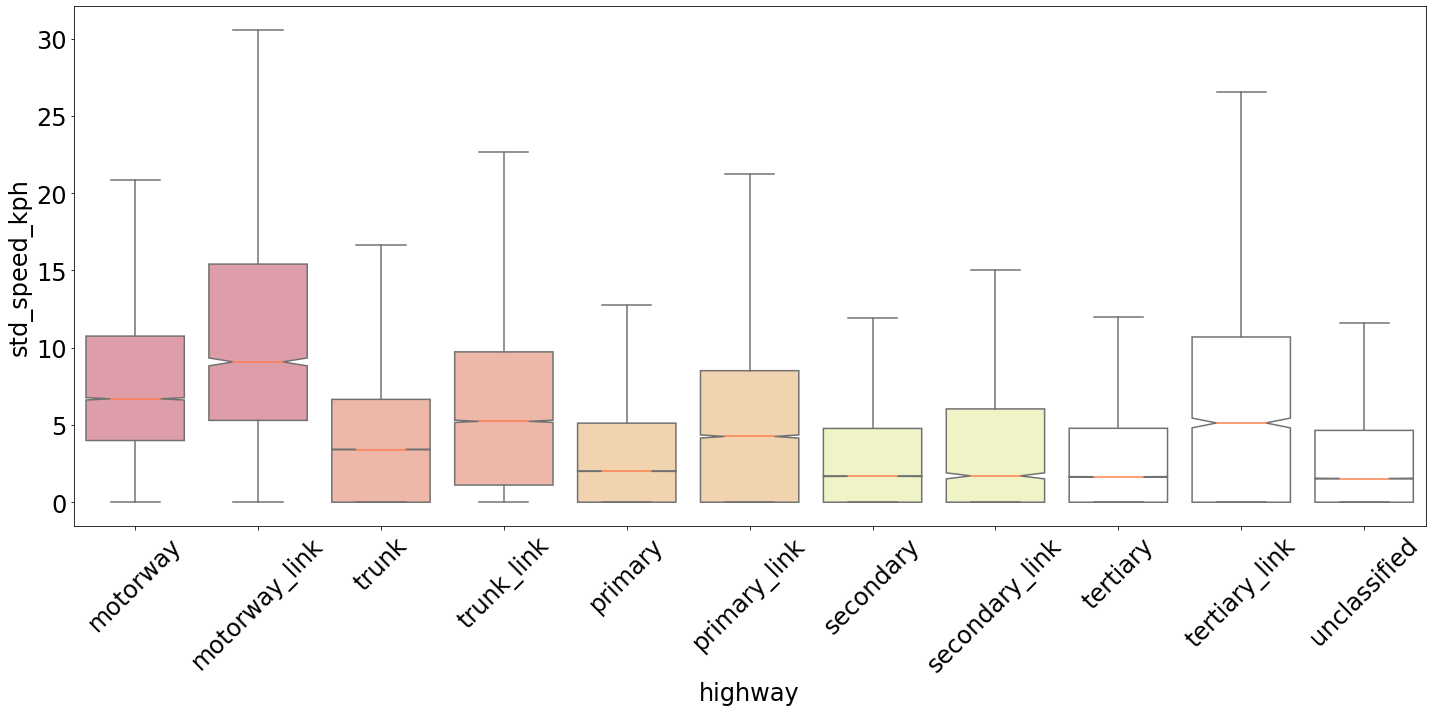

In [31]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]], 
            x="highway",
            y="std_speed_kph",  
            notch=True, 
            sym='',
            palette=osm_color_palette(),
            medianprops={"color": "coral"},
            ax=ax)
ax.tick_params(axis='x', which='major', labelsize=24, rotation=45)
ax.tick_params(axis='y', which='major', labelsize=24)
#  t4c: higher stds in link classes than in the corresponding road class they link -> plausibily, they get probes from the higher class running parallel.
plt.savefig(f"{CITY.title()}_t4c_std_speed_kph.png")

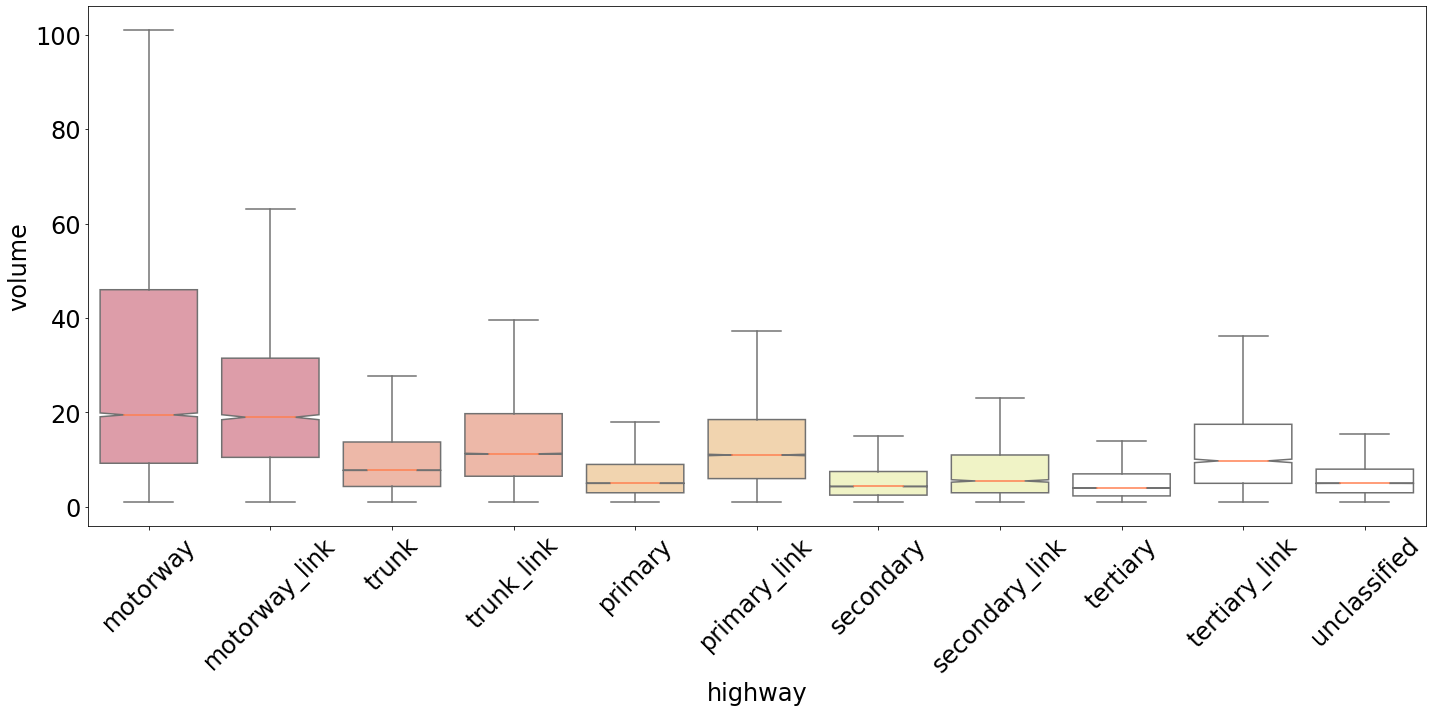

In [32]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]], 
            x="highway",
            y="volume",  
            notch=True, 
            sym='',
            palette=osm_color_palette(),
            medianprops={"color": "coral"},
            ax=ax)
ax.tick_params(axis='x', which='major', labelsize=24, rotation=45)
ax.tick_params(axis='y', which='major', labelsize=24)
# t4c: higher volumes on links than on the class below -> plausibily, they get probes from the higher class running parallel.
plt.savefig(f"{CITY.title()}_t4c_volume.png")

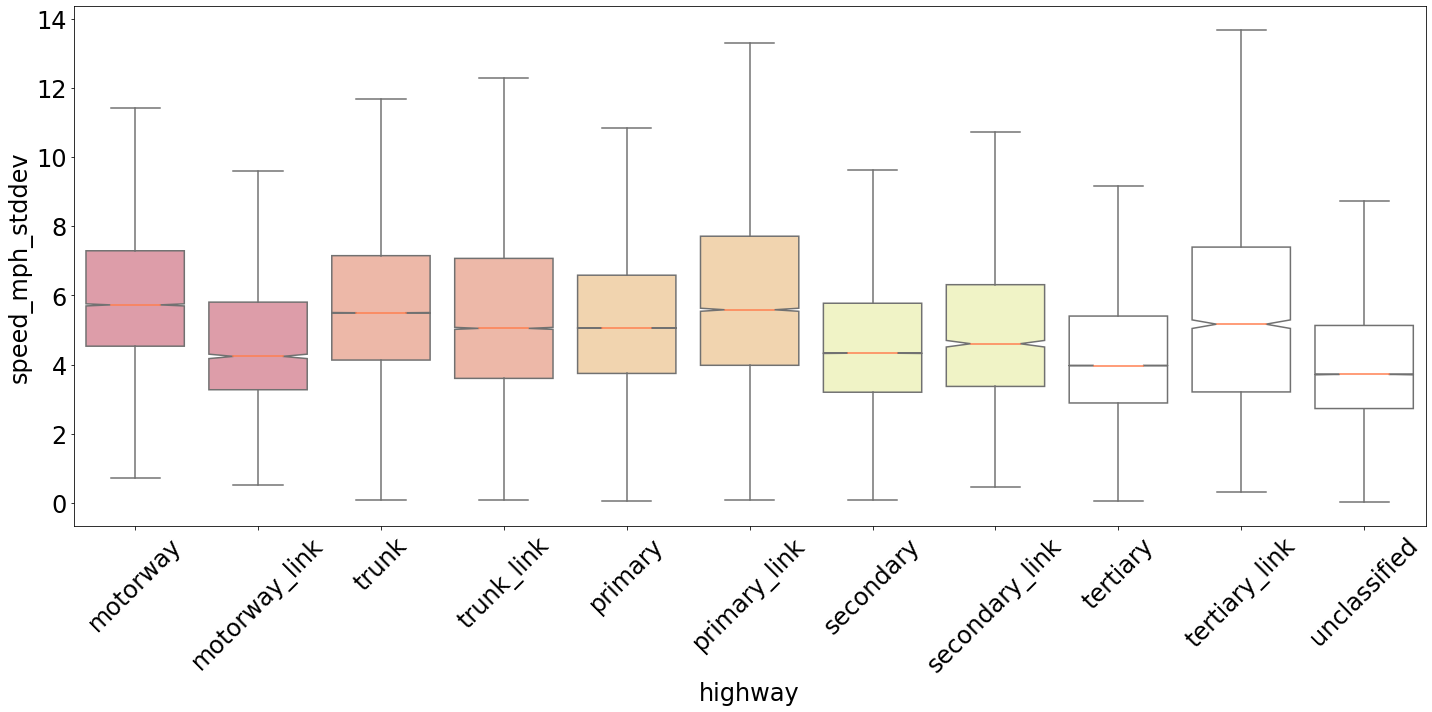

In [33]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]], 
            x="highway",
            y="speed_mph_stddev",  
            notch=True, 
            sym='',
            palette=osm_color_palette(),
            medianprops={"color": "coral"},
            ax=ax)
ax.tick_params(axis='x', which='major', labelsize=24, rotation=45)
ax.tick_params(axis='y', which='major', labelsize=24)
# Uber: link class have higher std than the class they link to (apart from motorway) -> acceleration/deceleration on links plausible
plt.savefig(f"{CITY.title()}_Uber_speed_mph_stddev.png")

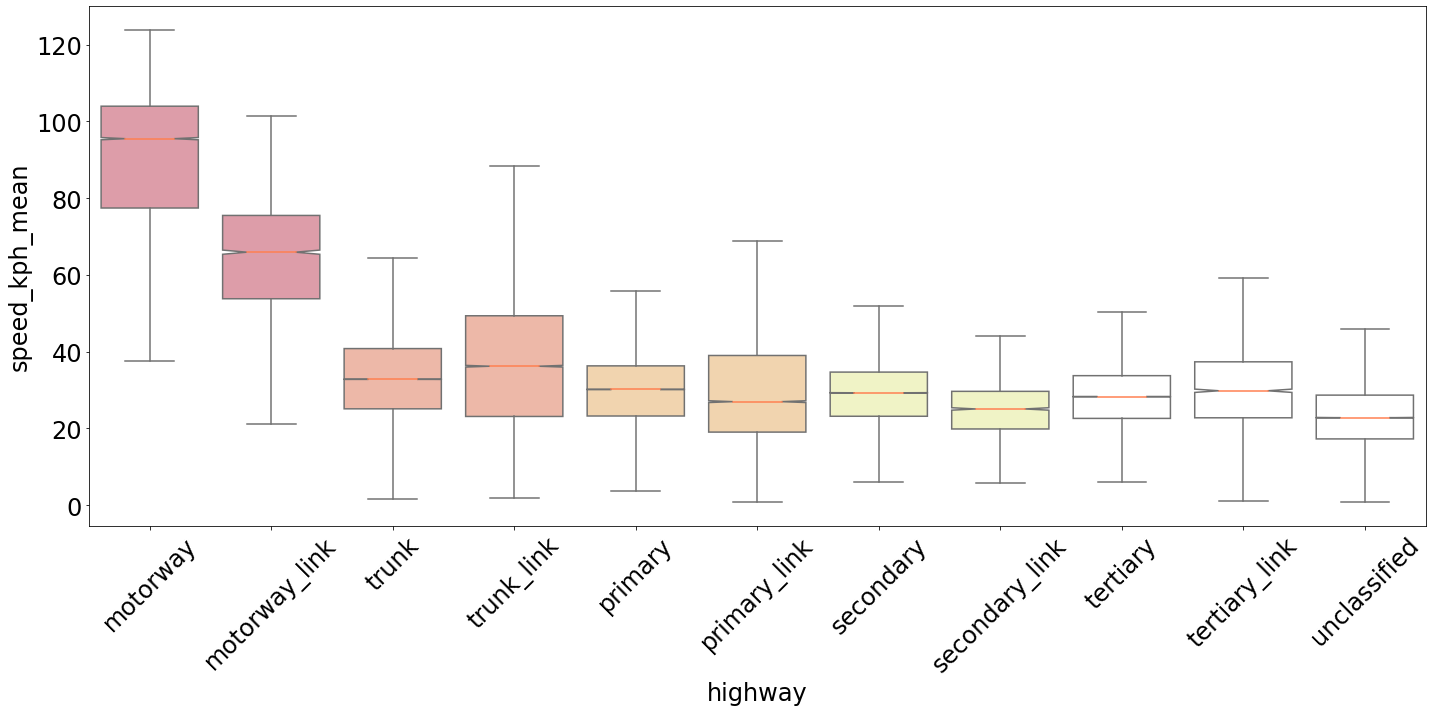

In [34]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
# sns.boxplot(ut_merged, x='highway', y='speed_kph_mean', ax=ax, palette=osm_color_palette())
sns.boxplot(ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]], 
            x="highway",
            y="speed_kph_mean",  
            notch=True, 
            sym='',
            palette=osm_color_palette(),
            medianprops={"color": "coral"},
            ax=ax)
ax.tick_params(axis='x', which='major', labelsize=24, rotation=45)
ax.tick_params(axis='y', which='major', labelsize=24)
plt.savefig(f"{CITY.title()}_Uber_speed_kph_mean.png")

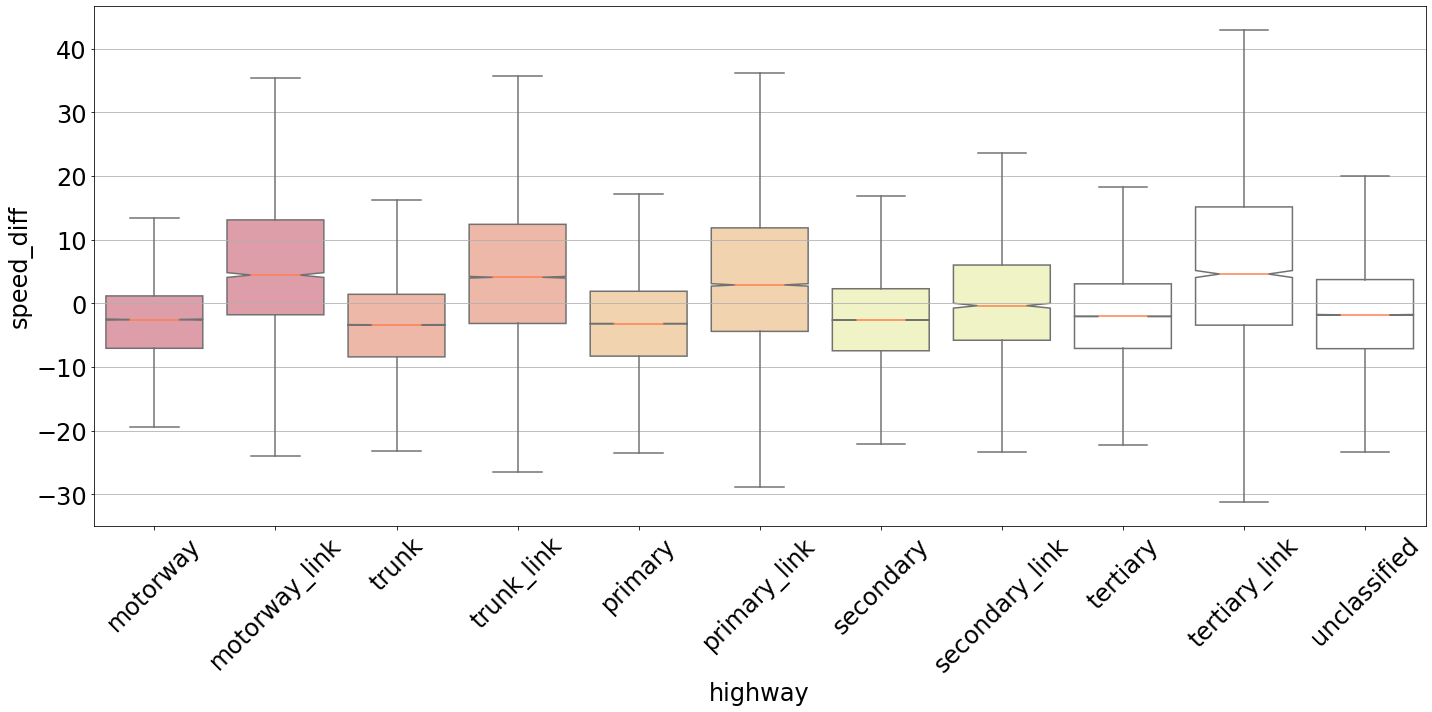

In [35]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
plt.rcParams["axes.labelsize"] = 24
sns.boxplot(ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]], 
            x="highway", 
            y="speed_diff",  
            notch=True, 
            sym='',
            palette=osm_color_palette(),
            medianprops={"color": "coral"},
            ax=ax)

ax.tick_params(axis='x', which='major', labelsize=24, rotation=45)
ax.tick_params(axis='y', which='major', labelsize=24)
ax.grid(axis='y')
plt.savefig(f"{CITY.title()}_Uber_speed_diff.png")

In [36]:
df_edges[df_edges["u"]==3240063179]

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
220959,3240063179_1249708436_8599345,3240063179,1249708436,8599345,32.2,20 mph,primary,,,,4.346146,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00t\x1e_\x...,London Bridge,3240063179,-0.088403,51.506295,1249708436,-0.088381,51.506327,True


In [37]:
tspeeds_df.columns

Index(['u', 'v', 'gkey', 'year', 'month', 'day', 'hour', 'volume_class',
       'volume', 'std_speed_kph', 'median_speed_kph', 'free_flow_kph'],
      dtype='object')

In [38]:
def plot_dayline(u,v,day):
    fig, ax = plt.subplots(1, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True)
    ax2 = ax.twinx()
    
    
    t_data = tspeeds_df[(tspeeds_df["u"]==u)&(tspeeds_df["v"]==v)&(tspeeds_df["day"]==day)].sort_values("hour")
    sns.lineplot(t_data, x="hour", y="median_speed_kph", ax=ax, color="orange")
    sns.lineplot(t_data, x="hour", y="volume", ax=ax, color="red")
    ax.errorbar(t_data["hour"],t_data["median_speed_kph"] , yerr=t_data["std_speed_kph"], capsize=2, capthick=0.5, color="orange", linewidth=0.5, linestyle=":")
    
    u_data = uspeeds_df[(uspeeds_df["u"]==u)&(uspeeds_df["v"]==v)&(uspeeds_df["day"]==day)].sort_values("hour")
    sns.lineplot(u_data, x="hour", y="speed_kph_mean", ax=ax2, color="blue")
    ax.errorbar(u_data["hour"],u_data["speed_kph_mean"] , yerr=u_data["speed_mph_stddev"], capsize=2, capthick=0.5, color="blue", linewidth=0.5, linestyle=":")
    rec = df_edges[(df_edges["u"]==u)&(df_edges["v"]==v)].iloc[0]
    lims = [         min([u_data["speed_kph_mean"].min(), t_data["median_speed_kph"].min()]),  max([u_data["speed_kph_mean"].max(), t_data["median_speed_kph"].max()]) ]
    ax.set_ylim([0,120])
    ax2.set_ylim([0,120])
#     print(rec)
    plt.title(f"{rec['name']}, {rec['highway']} {rec['length_meters']:.2f}m")

In [39]:
#         # 3240063179	3153656030		['King William Street', 'London Bridge']
#         ("London bridge, northbound", 3240063179, 3153656030),
#         # 2180693488	1868411754	A3	Elephant and Castle
#         ("Elephant and castle, northbound", 2180693488, 1868411754),
#         #	1178910690	197630	0		A40	['Marylebone Flyover', 'Westway']
#         ("Marylebone flyover, eastbound", 2180693488, 1868411754),
#         # 195975	28419372		M25		motorway
#         ("M25 near Waltham, eastbound", 195975, 28419372),
#         # 	208885668	257550997	M25		motorway
#         ("M25 near Potters Bar, westbound", 208885668, 257550997)

### "London bridge, northbound"

In [40]:
# u = 3240063179, v = 1249708436,

In [41]:
u = 1249708436 
v = 25161387

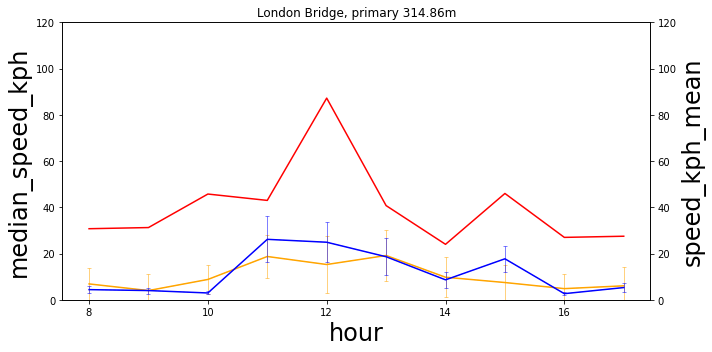

In [42]:
plot_dayline(u = u, v = v, day=21)

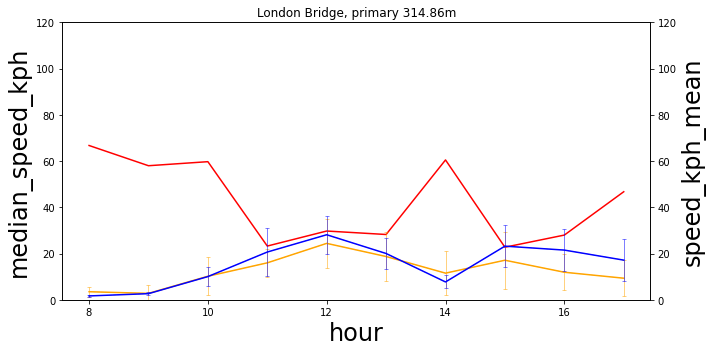

In [43]:
plot_dayline(u = u, v = v, day=22)

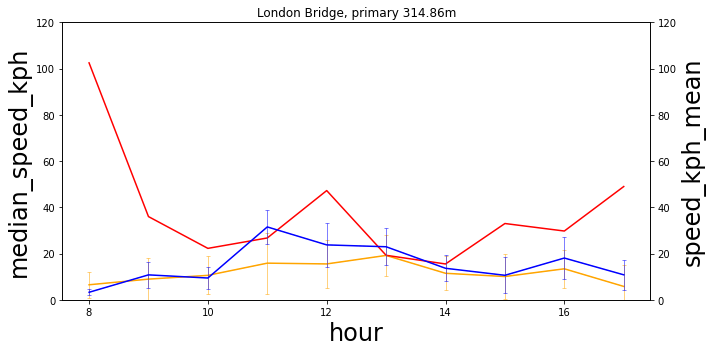

In [44]:
plot_dayline(u = u, v = v, day=23)

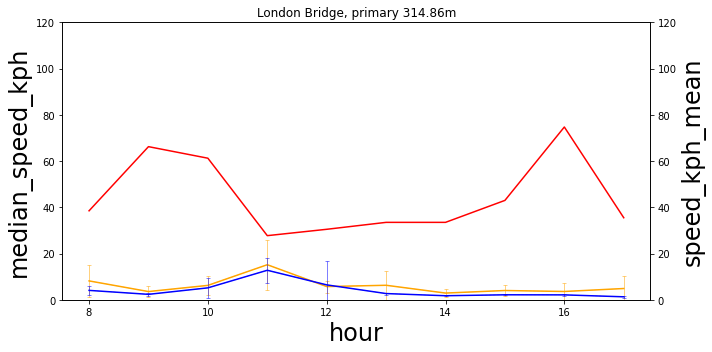

In [45]:
plot_dayline(u = u, v = v, day=24)

###         ("Marylebone flyover, eastbound", 2180693488, 1868411754),

In [46]:
u = 2180693488
v = 3890206825

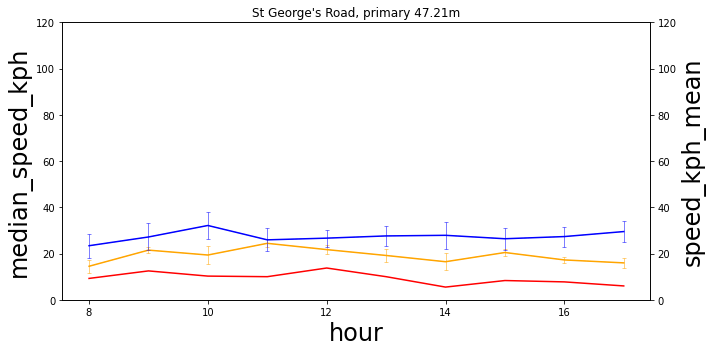

In [47]:
plot_dayline(u = u, v = v, day=21)

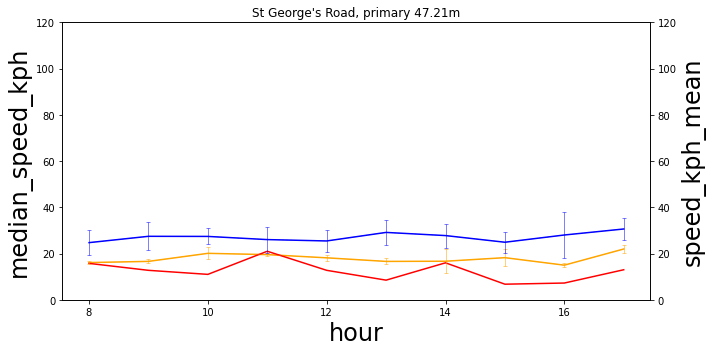

In [48]:
plot_dayline(u = u, v = v, day=22)

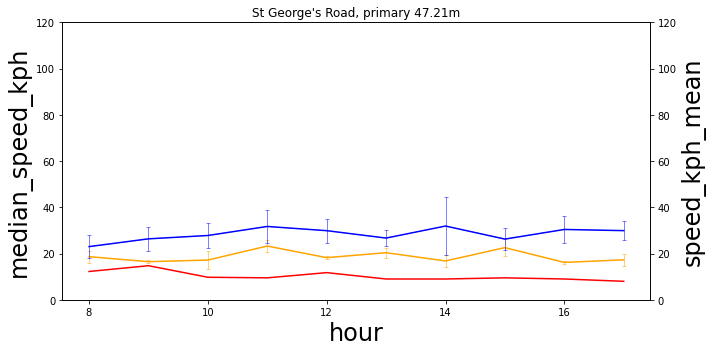

In [49]:
plot_dayline(u = u, v = v, day=23)

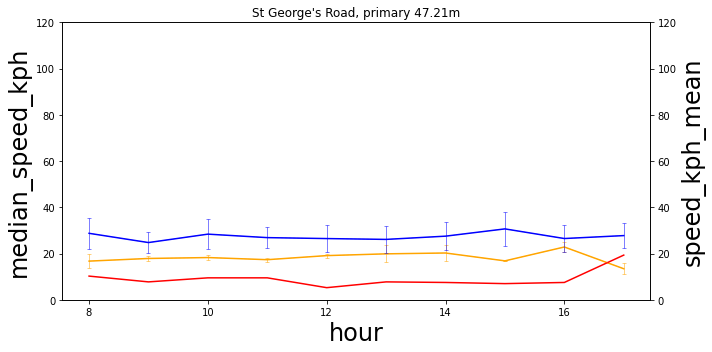

In [50]:
plot_dayline(u = u, v = v, day=24)

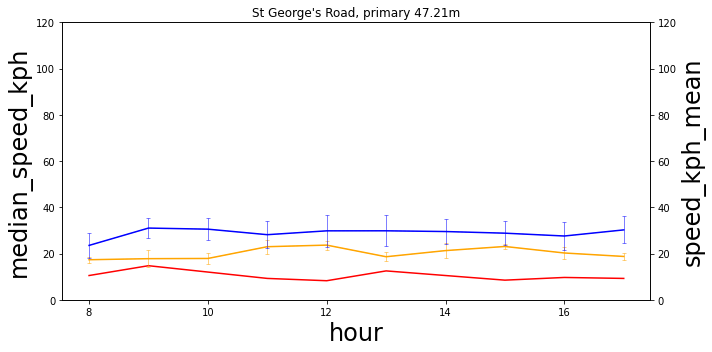

In [51]:
plot_dayline(u = u, v = v, day=25)

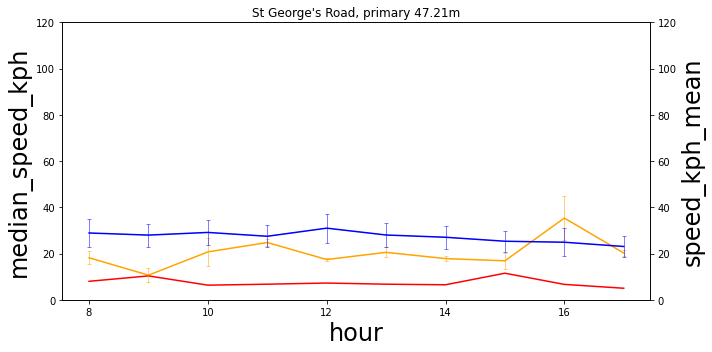

In [52]:
# Saturday
plot_dayline(u = u, v = v, day=26)

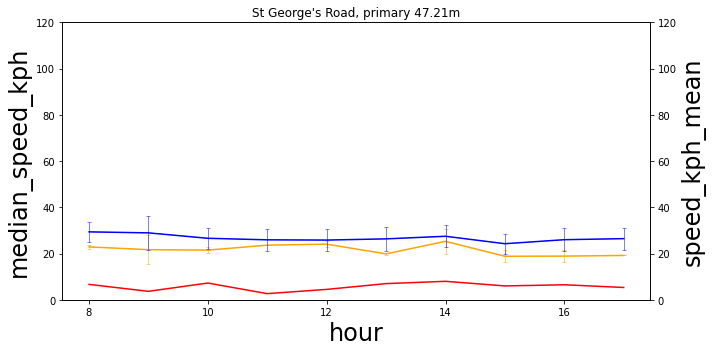

In [53]:
plot_dayline(u = u, v = v, day=27)

### ("M25 near Waltham, eastbound", 195975, 28419372),

In [54]:
u = 195975
v = 195965

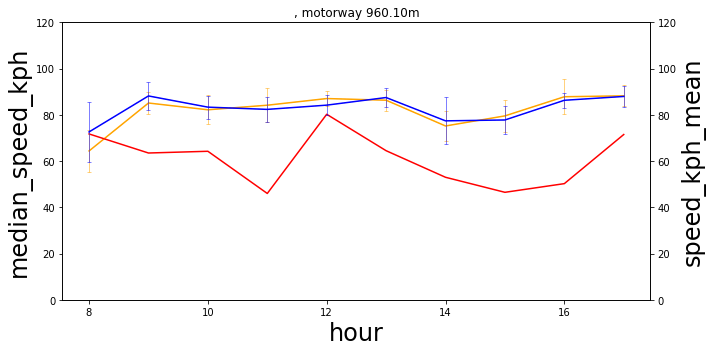

In [55]:
plot_dayline(u = u, v = v, day=21)

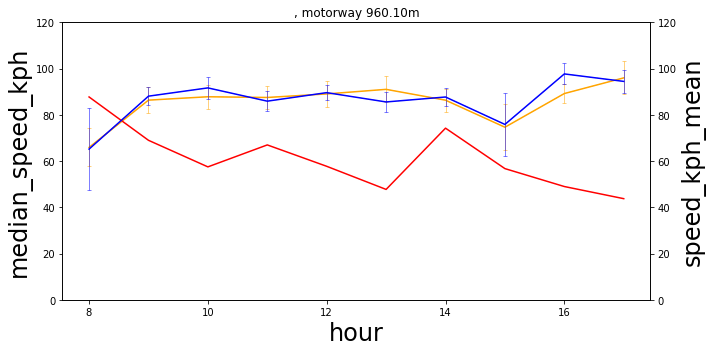

In [56]:
plot_dayline(u = u, v = v, day=22)

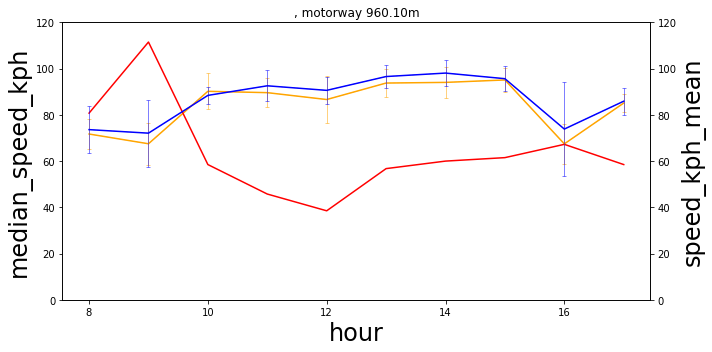

In [57]:
plot_dayline(u = u, v = v, day=23)

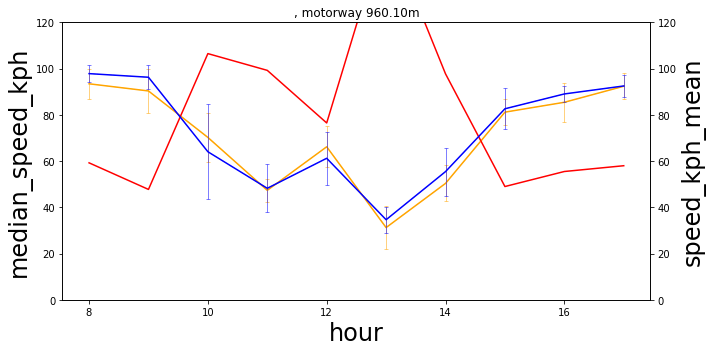

In [58]:
plot_dayline(u = u, v = v, day=24)

###  ("M25 near Potters Bar, westbound", 208885668, 257550997)

In [59]:
u = 208885668
v = 195875

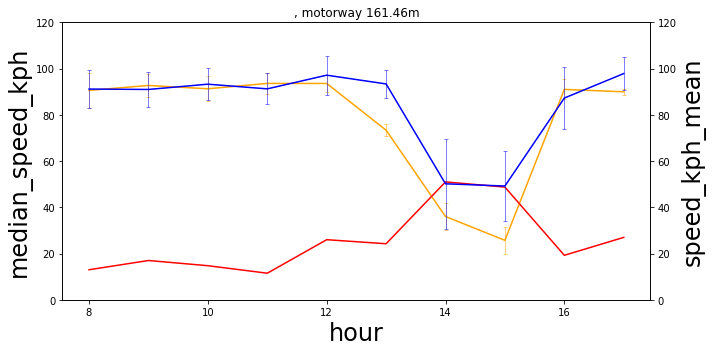

In [60]:
plot_dayline(u = u, v = v, day=21)

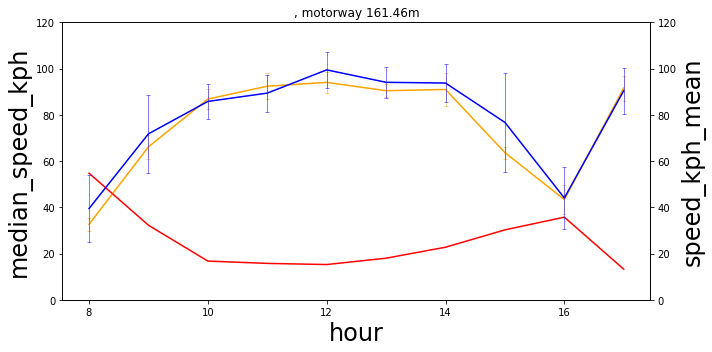

In [61]:
plot_dayline(u = u, v = v, day=22)

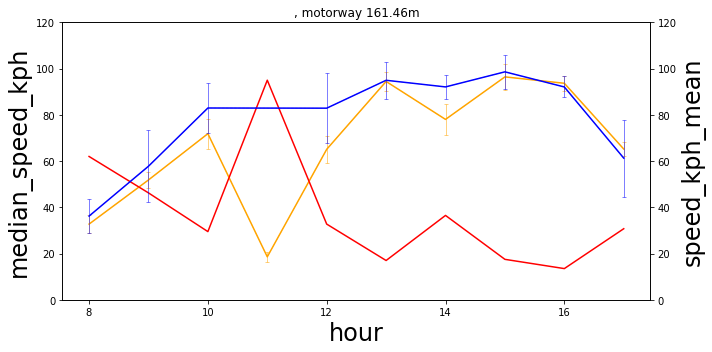

In [62]:
plot_dayline(u = u, v = v, day=23)